# Compare seismic features with geodetic data

These features were calculated on the `kebo` machine with  approximately ten years of continuous data (broadband and three-components). They used long-duration windows (typically half hour long) and twenty-ish components and clusters. The goal is to investigate the relationship with the geodetic data.

In [86]:
import os
import pickle

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import figures

## Global parameters

In [87]:
NETWORK = "network_1"
POOLING = "max"
REDUCTION = "fastica_30"
CLUSTERING = "kmeans_30"
SUFFIX = f"{REDUCTION}_{CLUSTERING}"
DIRPATH_FIGURES = f"./paper/{POOLING}"
FILEPATH_DATABASE = "./data/mseed_database/IG.ARIG.BH.sqlite-index.pkl"
FILEPATH_NETWORK = f"./model/{NETWORK}.pkl"
FILEPATH_SCATTERINGS = f"./out/{NETWORK}_{POOLING}.pkl"
FILEPATH_CLUSTERS = f"./out/{NETWORK}_{POOLING}_{SUFFIX}.pkl"
FILEPATH_CATALOG = "./data/catalogs/tremors_S1_husker.csv"
FILEPATH_GPS = "data/gps/gps_detrended_smooth_30.pkl"

# Create the directory for the figures if it does not exist.
os.makedirs(DIRPATH_FIGURES, exist_ok=True)

# Print out file
print(f"Filepath database: {FILEPATH_DATABASE}")
print(f"Filepath network: {FILEPATH_NETWORK}")
print(f"Filepath scatterings: {FILEPATH_SCATTERINGS}")
print(f"Filepath clusters: {FILEPATH_CLUSTERS}")
print(f"Filepath catalog: {FILEPATH_CATALOG}")
print(f"Dirpath figures: {DIRPATH_FIGURES}")

Filepath database: ./data/mseed_database/IG.ARIG.BH.sqlite-index.pkl
Filepath network: ./model/network_1.pkl
Filepath scatterings: ./out/network_1_max.pkl
Filepath clusters: ./out/network_1_max_fastica_30_kmeans_30.pkl
Filepath catalog: ./data/catalogs/tremors_S1_husker.csv
Dirpath figures: ./paper/max


## Read results

Some outputs were downloaded locally.

In [88]:
# Load the features
data = pickle.load(open(FILEPATH_CLUSTERS, "rb"))
print(f"Clusters loaded from {FILEPATH_CLUSTERS}")

# Load the gps data
gps = pickle.load(open(FILEPATH_GPS, "rb"))
print(f"Geodetic data loaded from {FILEPATH_GPS}")

# Get if x is features or clusters
x_feature_name = "cluster"
n_features = len(data.cluster)

Clusters loaded from ./out/network_1_max_fastica_30_kmeans_30.pkl
Geodetic data loaded from data/gps/gps_detrended_smooth_30.pkl


## Everybody on the same page (interpolate on same dates)

We also observe the smoothed features in order to better investigate long-duration trends in the features. We do this with a rolling windows associated with a mean. The result is non-causal (centered) with a minimum sample of 1.

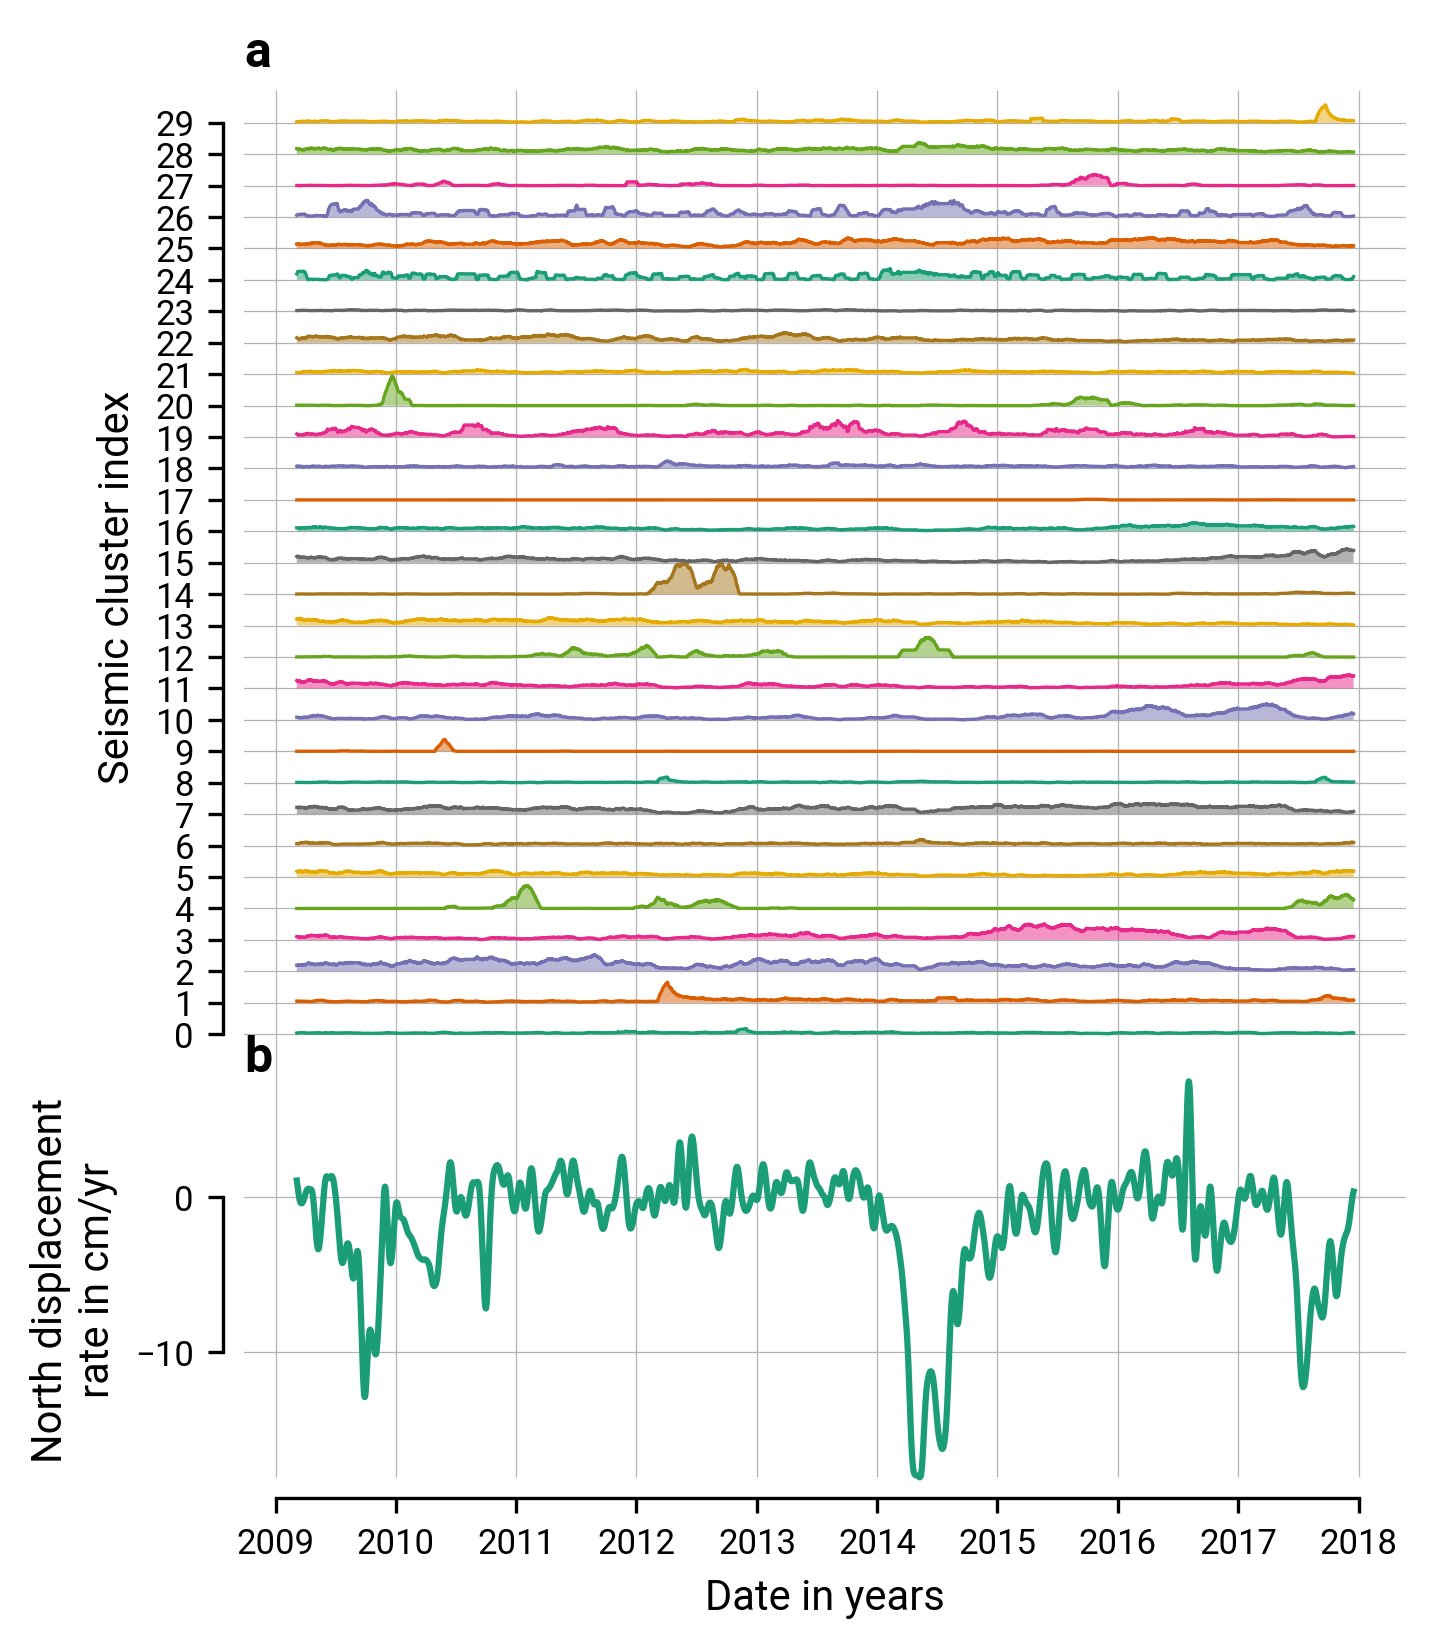

In [89]:
# Define a common time axis
start = max(gps.time.min(), data.time.min())
end = min(gps.time.max(), data.time.max())
step = np.timedelta64(6, "h")
times = np.arange(start.data, end.data, step)

# Interpolate
x_interp = data.clusters.copy().rolling(time=30 * 2 * 24, center=True).mean()
x_slow = x_interp.interp(time=times)
x_slow = x_slow.dropna("time")

# Normalize
x_norm = x_slow.copy()
x_norm /= x_norm.max()

# Limit y to the same time period as x
gps = gps.sel(time=slice(data.time.min(), data.time.max()))

# Resample and interpolate
y_interp = gps.resample(time="6h").interpolate().interp(time=x_slow.time)

# Plot
sns.set_palette("Dark2")
ax = figures.compare(x_norm, y_interp, components=("north",))

# Subplots
ax[0].set_ylim(-1.5, len(x_norm.cluster))
ax[0].set_yticks(np.arange(len(x_norm.cluster)))
ax[0].set_title("a", loc="left")
ax[1].set_title("b", loc="left", pad=-20, va="top")
sns.despine(ax=ax[0], trim=True, offset=5, bottom=True)
sns.despine(ax=ax[1], trim=True, offset=5)

# Show 
ax[0].figure.savefig(f"{DIRPATH_FIGURES}/e2_prepare_{SUFFIX}.pdf", bbox_inches="tight")

## Regression with scikit-learn

/gpfs/users/seydoux/.conda/envs/scatnet_tremors/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+03, tolerance: 2.240e+01
  model = cd_fast.enet_coordinate_descent(


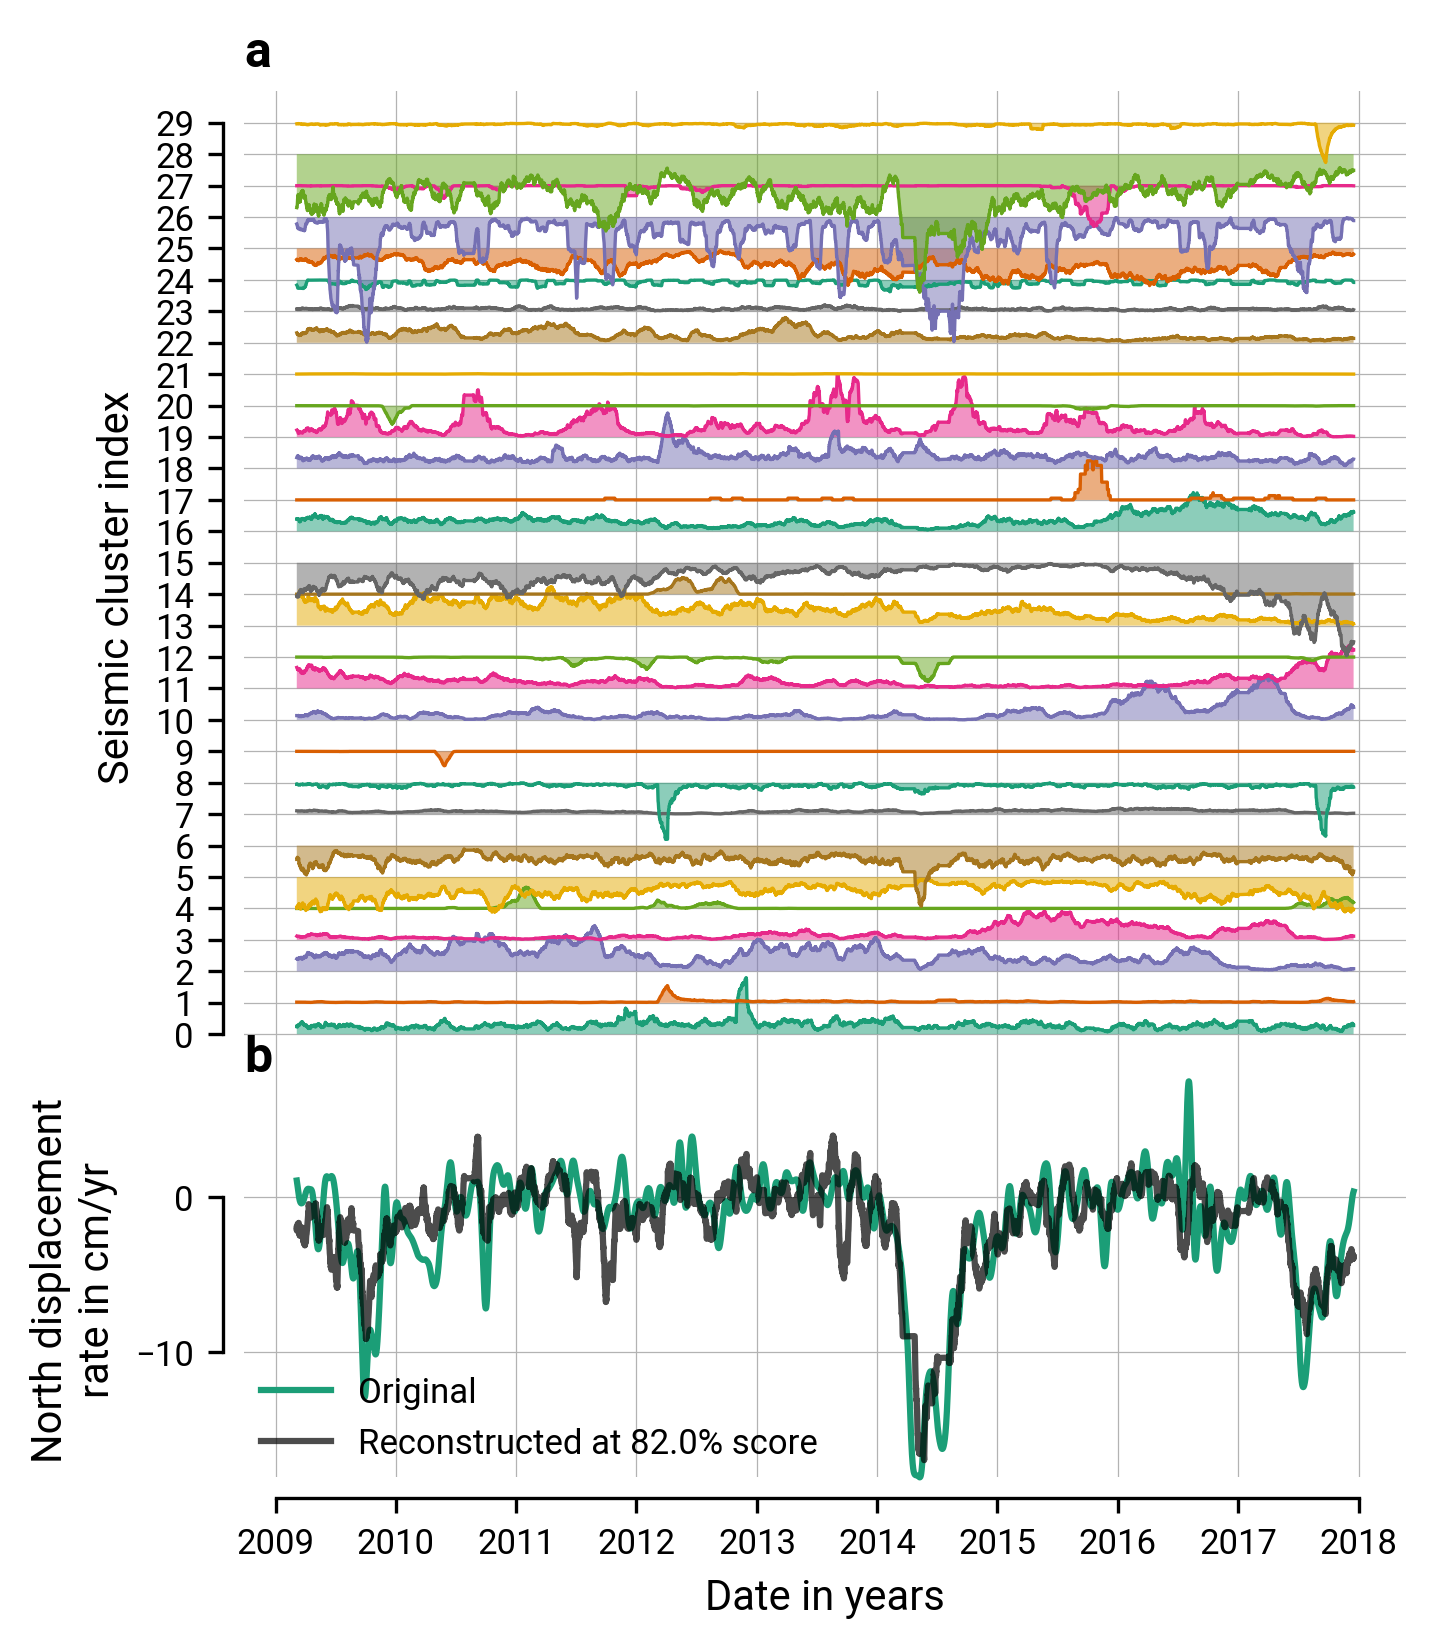

In [90]:
# from sklearn import svm
from sklearn.linear_model import Lasso

EXPO = 1.3

# Define design matrix
x_norm = x_slow.copy()  # - x_slow.min(dim="time")
design = x_norm.T.copy() ** EXPO

# Filter out unwanted components
target = y_interp.sel(component="north", drop=True).copy()

# Solve linear system
model = Lasso(fit_intercept=False, alpha=0.00001)
# model = svm.SVR()
model.fit(design.to_numpy().T, target.to_numpy())

# Reconstruct
prediction = target.copy()
prediction.values = model.predict(design.to_numpy().T)

# Overall score
score = np.corrcoef(target.values, prediction.values)[0, 1]

# Weighted inputs
# x_weighted = coefficients[:, None] * design 
# x_weighted /= x_weighted.max()
x_weighted = design.copy()
for index in range(len(x_weighted.cluster)):
    selected = design.where(design.cluster == index, 0)
    x_weighted[index] = model.predict(selected.to_numpy().T)
x_weighted /= x_weighted.max() / 2

# Subplots
sns.set_palette("Dark2")
ax = figures.compare(x_weighted.T, y_interp.T, components=("north",))
ax[-1].set_ylim(target.values.min(), target.values.max())
ax[-1].plot(prediction.time, prediction, alpha=0.7, c="k")
ax[0].set_ylim(-1.5, len(x_weighted.cluster))
ax[0].set_yticks(np.arange(len(x_weighted.cluster)))
ax[0].set_title("a", loc="left")
ax[1].set_title("b", loc="left", pad=-20, va="top")
sns.despine(ax=ax[0], trim=True, offset=5, bottom=True)
sns.despine(ax=ax[1], trim=True, offset=5)
ax[1].legend(["Original", f"Reconstructed at {score:0.1%} score"], loc="lower left")

# Show 
plt.savefig(f"{DIRPATH_FIGURES}/e2_compare_{EXPO}_{SUFFIX}.pdf", bbox_inches="tight")

## Contributions

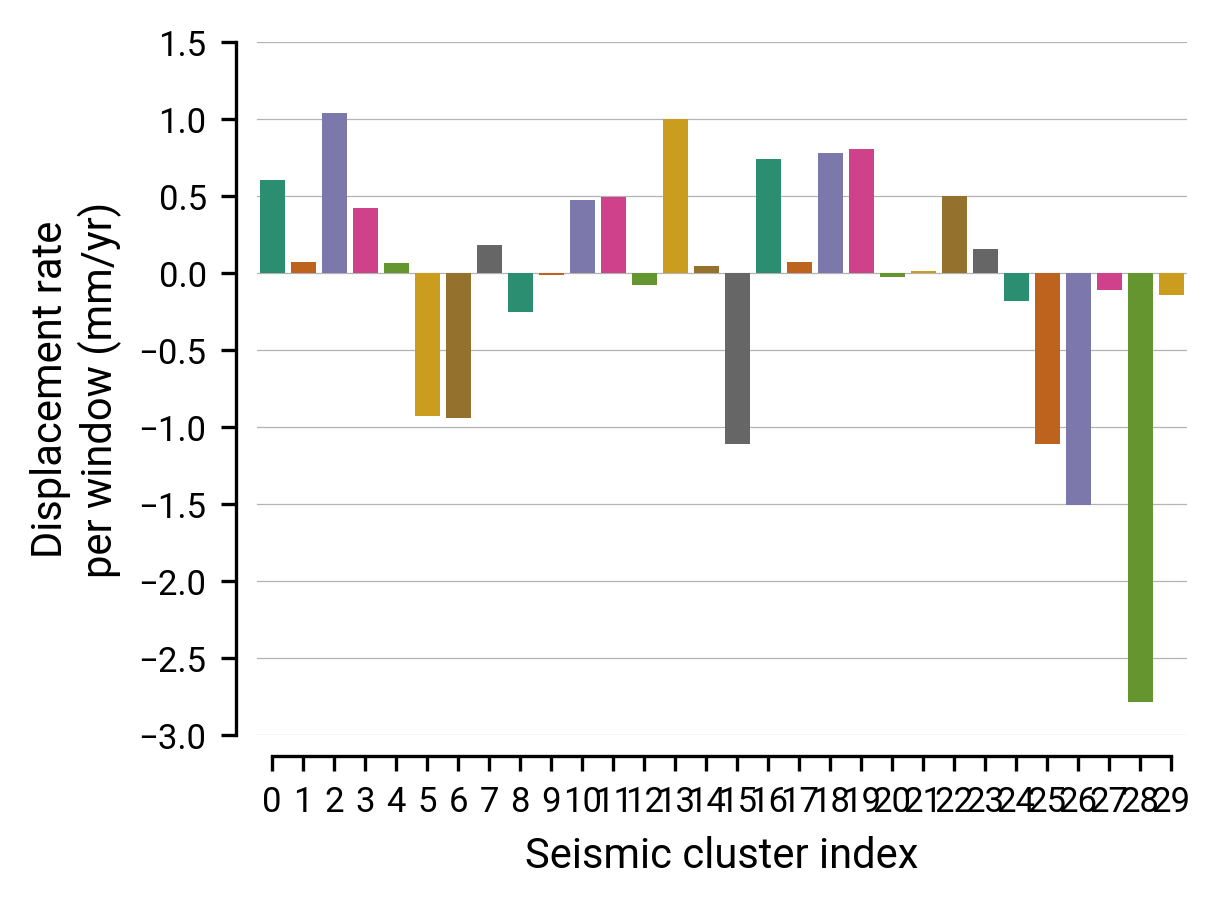

In [91]:
fig = plt.figure()
ax = plt.axes()

# Contributions
contributions = model.coef_ * design.mean(dim="time")

# Plot
sns.barplot(x=np.arange(len(model.coef_)), y=contributions, palette="Dark2", ax=ax)

# Seaborn style
ax.grid(True, axis="y")
sns.despine(ax=ax, offset=5, trim=True)
ax.set_xlabel("Seismic cluster index")
ax.set_ylabel("Displacement rate\nper window (mm/yr)")

# Save
plt.savefig(f"{DIRPATH_FIGURES}/e3_contributions_{EXPO}_{SUFFIX}.pdf", bbox_inches="tight")